**Zadanie 1**  
Wczytaj plik `zamowienia.csv` do ramki pandas, a następnie w kilku miejscach (ale nie w pierwszych 10 wierszach) wstaw wartość NaN, aby zasymulować wartości brakujące. Zapisz ramkę do pliku `zamowienia_missing.csv`. Wczytaj teraz plik do ramki Dask i sprawdź jakie typy danych zostały przydzielone. Czy zgadzają się z typami z oryginalnego pliku? Wykonaj dowolne obliczenia na całej ramce Dask, aby wymusić wywołanie `.compute()`. Czy pojawił się błąd dotyczący niespójności typów danych? Spróbuj uruchomić kilka razy funkcję wczytywania danych do ramki Dask dataframe z różnymi wartościami parametru `samples`. Dokumentacja `dask.dataframe.read_csv()`: [https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html)

In [1]:
import pandas as pd
import numpy as np

zamowienia = pd.read_csv('zamowienia.csv')
# zamowienia.to_csv('zamowienia_missing.csv', index=False)

In [2]:
import dask.dataframe as dd

ddf = dd.read_csv('zamowienia_missing.csv', sep=';', assume_missing=True)
# ddf = dd.read_csv('zamowienia_missing.csv', sep=';')
print(ddf.dtypes)
ddf.compute()

Kraj               string[pyarrow]
Sprzedawca         string[pyarrow]
Data zamowienia    string[pyarrow]
idZamowienia               float64
Utarg                      float64
dtype: object


,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg
0,Polska,Kowalski,2003-07-16,10248.0,440.00
1,Polska,Sowiński,2003-07-10,10249.0,1863.40
2,Niemcy,Peacock,2003-07-12,10250.0,1552.60
3,Niemcy,Leverling,2003-07-15,10251.0,654.06
4,Niemcy,Peacock,2003-07-11,10252.0,3597.90
...,...,...,...,...,...
794,Polska,King,2005-04-30,11048.0,525.00
795,Niemcy,Leverling,2005-05-01,11052.0,1332.00
796,Niemcy,Fuller,2005-04-29,11053.0,3055.00
797,Niemcy,Callahan,2005-05-01,11056.0,3740.00


In [3]:
ddf[ddf['Kraj'] == 'Polska']['Utarg'].sum().compute()

np.float64(332496.70999999996)

Samo `.compute()` podaje błąd ze względu na brakujące wartości (jeśli nie podamy `assume_missing=True`), w kolumnie `'Utarg'` również są wartości NaN.

In [4]:
# samples
ddf_sampled = dd.read_csv('zamowienia_missing.csv', assume_missing=True, sep=';', sample=1024)
ddf_sampled[ddf_sampled['Kraj'] == 'Polska']['Utarg'].sum().compute()

np.float64(332496.70999999996)

In [5]:
ddf_sampled = dd.read_csv('zamowienia_missing.csv', assume_missing=True, sep=';', sample=4096)
ddf_sampled[ddf_sampled['Kraj'] == 'Polska']['Utarg'].sum().compute()

np.float64(332496.70999999996)

In [6]:
ddf_sampled = dd.read_csv('zamowienia_missing.csv', assume_missing=True, sep=';', sample=64)
ddf_sampled[ddf_sampled['Kraj'] == 'Polska']['Utarg'].sum().compute()

np.float64(332496.70999999996)

**Zadanie 2**  
Ze strony [https://docs.dask.org/en/stable/dashboard.html](https://docs.dask.org/en/stable/dashboard.html) skonfiguruj plugin Dask dashboard dla Jupyter Lab i przetestuj jego działanie.

In [7]:
from dask.distributed import Client
client = Client()
client

In [8]:
import dask.array as da

# przetestuj działanie
x = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
y = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1,2))
z.compute()

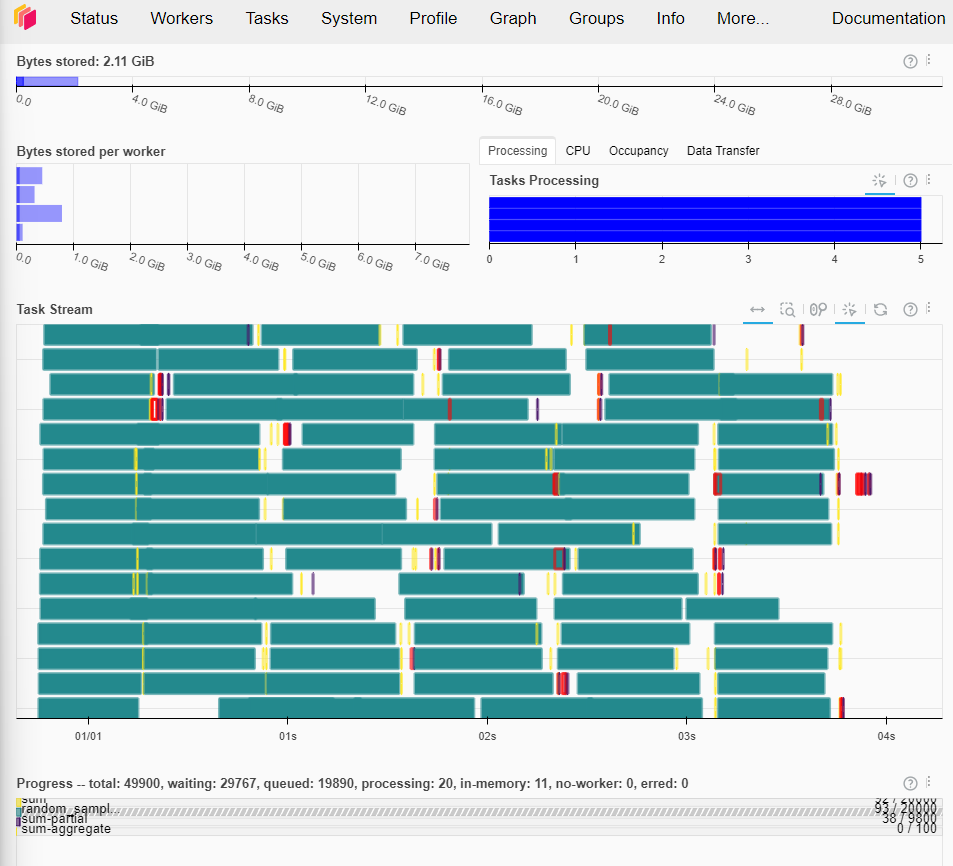

**Zadanie 3**  
Skonfiguruj lokalny klaster (`Client`) tak, aby nie zaalokował wszystkich zasobów (np. zostaw 8 GB RAM dla systemu hosta + 2 rdzenie). Pobierz dane udostępnione na poprzednich zajęciach ([https://huggingface.co/datasets/vargr/private_instagram/tree/main/data](https://huggingface.co/datasets/vargr/private_instagram/tree/main/data)) i załaduj do ramki Dask tyle części ile zdołasz w formie bez optymalizacji. Zmierz czas tej operacji.

In [2]:
import time
import dask.dataframe as dd
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit='28GB')
client

start_time = time.time()
ddf_insta = dd.read_parquet('../*.parquet')
ddf_insta.compute()
end_time = time.time()
print(f"Czas ładowania danych: {end_time - start_time} sekund")


Czas ładowania danych: 136.9166660308838 sekund


**Zadanie 4**  
Wykonaj kilka operacji na klastrze lokalnym z danymi z zadania 3:

- wyświetl top 10 użytkowników z najwyższą liczbą like'ów,
- pobierz dane tylko za pierwsze półrocze 2019 roku. Każdorazowo zmierz i wyświetl czas operacji i obserwuj dashboard.

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
import time

client = Client(n_workers=2, threads_per_worker=2, memory_limit='28GB')
client

ddf = dd.read_parquet('../*.parquet')

# top 10
start_time = time.time()
top_10_users = ddf.groupby('username')['likes'].sum().nlargest(10).compute()
end_time = time.time()
print(f"Top 10 users w/ highest likes:\n{top_10_users}")
print(f"Time: {end_time - start_time} seconds")

# half of 2019
start_time = time.time()
ddf['date'] = dd.to_datetime(ddf['date'])
first_half_2019 = ddf[(ddf['date'] >= '2019-01-01') & (ddf['date'] <= '2019-06-30')].compute()
end_time = time.time()
print(f"First half of 2019:\n{first_half_2019}")
print(f"Time: {end_time - start_time} seconds")


Top 10 users w/ highest likes:
username
lilireinhart     40375292
instagram        29864166
jamescharles     26067462
lizakoshy        19217644
elle             17494288
433              16457870
amandacerny      15019135
saraalikhan95    14199489
zkdlin           13799100
akshaykumar      13352324
Name: likes, dtype: int64
Time: 4.041318893432617 seconds
First half of 2019:
              sid  sid_profile      post_id  profile_id                date  \
2        28370905      3496776  Bunhd1DFVAG  2237947779 2019-03-05 08:03:11   
4        32170690      3496776  BuDfIyslzfw  2237947779 2019-02-19 08:10:11   
5        14315358      3496776  BxJsMDpA2yH  2237947779 2019-05-07 08:33:51   
6         8304346      3496776  Bt5LFpZlm3z  2237947779 2019-02-15 08:02:35   
7        14315346      3496776  BxZIzaQhS-o  2237947779 2019-05-13 08:32:30   
...           ...          ...          ...         ...                 ...   
1147349  28364854      1313976  Bt4CYsJFHo0   360287303 2019-02-14 21

**Zadanie 5**  
Wczytaj te same dane do ramki Dask co w zadaniu 3, ale podaj typy danych, które zostały wybrane w procesie optymalizacji wykonanej w zadaniach z lab 01. Porównaj czas ładowania z zadaniem 3. Wykonaj również te same operacje co w zadaniu 4 i porównaj czas. Śledź wykonanie zadań patrząc na graf wywołań.

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
import time
import pandas as pd

client = Client(n_workers=3, threads_per_worker=2, memory_limit='28GB')
client

dtype_opt = {
    'sid': np.int32,
    'post_id': 'category',
    'profile_id': 'category',
    'post_type': 'category',
    'description': 'str',
    'likes': np.int32,
    'comments': np.int32,
    'username': 'category',
    'bio': 'str',
    'followers': np.int32,
    'following': np.int32,
    'num_posts': np.int32,
    'lang': 'category',
    'category': 'category'
}

start_time = time.time()
ddf_optimized = dd.read_parquet('../*.parquet', dtype=dtype_opt)
ddf_optimized['date'] = dd.to_datetime(ddf_optimized['date'])
ddf_optimized.compute()
end_time = time.time()
print(f"Czas ładowania danych opt: {end_time - start_time} sekund")

start_time = time.time()
top_10_users_opt = ddf_optimized.groupby('username')['likes'].sum().nlargest(10).compute()
end_time = time.time()
print(f"Time for top 10 opt: {end_time - start_time} seconds")

start_time = time.time()
first_half_2019_opt = ddf_optimized[(ddf_optimized['date'] >= '2019-01-01') & (ddf_optimized['date'] <= '2019-06-30')].compute()
end_time = time.time()
print(f"Time for first half opt: {end_time - start_time} seconds")

Czas ładowania danych opt: 139.645592212677 sekund
Time for top 10 opt: 4.895451307296753 seconds
Time for first half opt: 38.71882891654968 seconds


**Zadanie 6**  
Podziel tablicę `darr` z przykładów na inne liczby chunków (eksperymentuj) i wykonaj te same obliczenie (średnia). Dla każdej liczby chunków wypisz czas obliczeń (wykonaj to samo obliczenie minimum 10 razy, aby nieco uwiarygodnić wyniki i uśrednij) i porównaj wyniki. Napisz wniosek o wynikach swoich eksperymentów i automatycznego podziału na chunki. Czy udało Ci się osiągnąć lepszą wydajność niż przy domyślnych ustawieniach?

In [1]:
import dask.array as da
import time
import numpy as np
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=2, memory_limit='24GB')
client

def measure_time_for_mean(darr, repeats=10):
    times = []
    for _ in range(repeats):
        start_time = time.time()
        darr.mean(axis=0).compute()
        end_time = time.time()
        times.append(end_time - start_time)
    return np.mean(times)

size = (20_000, 20_000)
chunk_sizes = [(2000, 2000), (4000, 4000), (5000, 5000), (10000, 10000), (20000, 20000)]
results = {}

for chunk in chunk_sizes:
    darr = da.random.normal(5, 0.2, size=size, chunks=chunk)
    avg_time = measure_time_for_mean(darr, repeats=10)
    results[chunk] = avg_time

# domyślne
darr_auto = da.random.normal(5, 0.2, size=size)
auto_time = measure_time_for_mean(darr_auto, repeats=10)
results['auto'] = auto_time

print("\nPorównanie:")
for chunk, avg_time in results.items():
    print(f"Chunks {chunk}: {avg_time:.4f} seconds")



Porównanie:
Chunks (2000, 2000): 1.3769 seconds
Chunks (4000, 4000): 1.3722 seconds
Chunks (5000, 5000): 1.1790 seconds
Chunks (10000, 10000): 1.6725 seconds
Chunks (20000, 20000): 4.5230 seconds
Chunks auto: 1.3215 seconds


In [2]:
overall_avg = 0
for chunk, avg_time in results.items():
    if chunk != 'auto':
        overall_avg += avg_time

print(f"Overall avg: {overall_avg/5:.4f} seconds")

Overall avg: 2.0247 seconds


Zbyt duże chunki zdecydowanie wykorzystywały zbyt dużo pamięci na pojedyncze zadania - stąd wyższy czas. W teorii mniejsze chunki to również problem - komunikacja między workerami czasami pada, ale akurat tutaj zdały się w miarę dobrze. Najlepszy był podział na *4 części - 5k wielokości chunka*. Czas auto jest niższy niż ogólna średnia, ale dopasowanie indywidualne pozwala na lepsze wyniki.